# SIADS 543 Unsupervised Learning (Week 4)
# Combining unsupervised and supervised methods

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Label propagation

#### There are two main classes for label propagation in scikit-learn: LabelPropagation and LabelSpreading. Both of these take the set of input data instances and construct a graph over the full dataset based on a pairwise similarity measure between points. The difference is in (a) how they implement the similarity measure and (b) how they strictly they 'clamp' input labels to specific values.

#### LabelPropagation is the simpler technique: it does 'hard' clamping of labels to values and does not modify the raw input similarity matrix.

In [2]:
from sklearn import datasets
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This function takes a dataset and label set as input, and returns the following:
#   - The X features of the subset of instances that had intact labels
#   - The y labels of the subset of instances that had intact labels
#   - The X features of the complete training set
#   - The y labels of the complete training set WITH DESTROYED LABELS according to the assignment specifications.
#
# input parameters frac_0, frac_1 indicate the probability you want to mangle class 0 and class 1 labels
# respectively.
def get_mangled_label_dataset(X_train, y_train, frac_0, frac_1):
    rng = np.random.RandomState(0)

    X_train_0 = X_train[y_train == 0]
    y_train_0 = y_train[y_train == 0]

    X_train_1 = X_train[y_train == 1]
    y_train_1 = y_train[y_train == 1]

    X_train_complete = np.vstack((X_train_0, X_train_1))
    y_train_complete = np.concatenate((y_train_0, y_train_1))

    random_unlabeled_points_0 = rng.rand(len(y_train_0)) < frac_0
    random_unlabeled_points_1 = rng.rand(len(y_train_1)) < frac_1
    random_unlabeled_points = np.concatenate((random_unlabeled_points_0, random_unlabeled_points_1))

    random_labeled_points_0 = np.logical_not(random_unlabeled_points_0)
    random_labeled_points_1 = np.logical_not(random_unlabeled_points_1)

    labeled_subset_X_train_0  = X_train_0[random_labeled_points_0]
    labeled_subset_X_train_1  = X_train_1[random_labeled_points_1]
    labeled_subset_y_train_0  = y_train_0[random_labeled_points_0]
    labeled_subset_y_train_1  = y_train_1[random_labeled_points_1]

    labeled_subset_X_train = np.vstack((labeled_subset_X_train_0, labeled_subset_X_train_1))
    labeled_subset_y_train = np.concatenate((labeled_subset_y_train_0, labeled_subset_y_train_1))

    labels_train_with_destroyed = np.copy(y_train_complete)
    labels_train_with_destroyed[random_unlabeled_points] = -1

    return (labeled_subset_X_train, labeled_subset_y_train, X_train_complete, labels_train_with_destroyed)

df = pd.read_csv("./spam.csv")

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

# fit a support vector machine to the complete dataset with undestroyed labels
svc_full = SVC()

svc_full.fit(X_train, y_train)
test_preds_full = svc_full.predict(X_test)
acc_full = accuracy_score(y_test, test_preds_full)
print ("SVM accuracy with full, complete data:", acc_full)

(labeled_subset_X_train, labeled_subset_y_train, X_train_complete, y_train_complete_missing) = \
     get_mangled_label_dataset(X_train, y_train, 0.05, 0.95)

SVM accuracy with full, complete data: 0.9192006950477846


In [3]:
from sklearn.semi_supervised import LabelPropagation
n_neighbors= 9

# In this example, we'll use a k-NN kernel on the graph. It produces a sparse but efficient graph.
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=n_neighbors, 
                                  max_iter=50, tol=0.001)

# call fit to build the similarity graph between items
label_prop_model.fit(X_train_complete, y_train_complete_missing)

# infer the missing labels.
pred_y_train_complete = label_prop_model.predict(X_train_complete) 

# NOTE: instead of the above line, we could have also used the transduction_ property of
# the LabelSpreading object, e.g.
#
#   pred_y_train_complete = label_prop_model.transduction_ 
#
# which stores the label output inferred for the data input to
# the fit method.  The predict method can also be used to predict for *new* data.

# fit a support vector machine to the complete dataset with inferred labels
svc_label_prop = SVC()

svc_label_prop.fit(X_train_complete, pred_y_train_complete)
test_preds_label_prop = svc_label_prop.predict(X_test)
acc_with_label_prop   = accuracy_score(y_test, test_preds_label_prop)
print ("SVM accuracy with LabelPropagation inferred labels on complete data:", acc_with_label_prop)

SVM accuracy with LabelPropagation inferred labels on complete data: 0.6038227628149435


#### LabelSpreading is more sophisticated: it does 'soft' clamping of labels to values, allowing them to be modified if the local evidence is strong enough, and computes a modified graph using a smoothed (regularized) form of the similarity matrix. The strictness of the label clamping is controlled by the `alpha` parameter: `alpha = 0` gives hard clamping and higher values of `alpha` relaxes the clamping factor.  The edge weights of the modified graph are normalized using the normalized graph Laplacian matrix, as described in the lecture.

In [4]:
from sklearn.semi_supervised import LabelSpreading
n_neighbors= 7

label_spread_model = LabelSpreading(kernel='knn', n_neighbors=n_neighbors, 
                                  alpha=0.1, max_iter=50, tol=0.001)
label_spread_model.fit(X_train_complete, y_train_complete_missing)
pred_y_train_complete = label_spread_model.predict(X_train_complete)

# fit a support vector machine to the complete dataset with inferred labels
svc_label_spread = SVC()

svc_label_spread.fit(X_train_complete, pred_y_train_complete)
test_preds_label_spread = svc_label_spread.predict(X_test)
acc_with_label_spread   = accuracy_score(y_test, test_preds_label_spread)
print ("SVM accuracy with LabelSpreading inferred labels on complete data:", acc_with_label_spread)

SVM accuracy with LabelSpreading inferred labels on complete data: 0.6715899218071243


### Data imputation

In [5]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes

# Some of the following code was adapted and modified from the scikit-learn impute documentation.

In [6]:

# This function takes a dataset X with labels y as input, and an optional
# "missing rate" that indicates the proportion of total instances (rows)
# that should have at least one missing value. It makes a copy of the input
# and returns the modified X, y as output.
def create_copy_with_missing_values(X, y, missing_rate = 0.75):
    n_samples, n_features = X.shape

    n_missing_samples = int(n_samples * missing_rate)
    
    # now pick which rows, columns should correspond to the missing samples
    missing_instances = rng.choice(n_samples, size=n_missing_samples, replace=False)
    missing_features  = rng.randint(0, n_features, n_missing_samples)
    
    X_missing = X.copy()
    y_missing = y.copy()

    X_missing[missing_instances, missing_features] = np.nan

    return X_missing, y_missing


In [7]:
# Here's an example that tries out multiple imputation strategies on the
# same missing-data scenario.  

rng = np.random.RandomState(42)
CV_SPLITS = 5
missing_rate = 0.95
regressor = RandomForestRegressor(random_state=42)
x_labels = ['Full data',
            'Simple imputation: always zero',
            'Simple imputation: mean',
            'Simple imputation: median',
            'Iterative imputation',
            'k-NN imputation',
           ]

score_type = 'r2'
n_entries = len(x_labels)
mses_dataset = np.zeros(n_entries)
stds_dataset = np.zeros(n_entries)

from sklearn.datasets import load_breast_cancer
(X_full, y_full) = load_breast_cancer(return_X_y = True)

X_missing, y_missing = create_copy_with_missing_values(X_full, y_full, missing_rate = missing_rate)

In [8]:
# Flagging missing information via connecting
# the imputer and regressor using a pipeline object

In [9]:
def get_scores_using_imputer(regressor, imputer,
                           X_missing, y_missing, score_type = score_type):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring=score_type,
                                    cv=CV_SPLITS)
    # print(impute_scores)
    return impute_scores

In [10]:
#### Simple imputation by replacing missing values by zero.

In [11]:
def get_impute_zero_score(regressor, X_missing, y_missing):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
    zero_impute_scores = get_scores_using_imputer(regressor, imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()

mses_dataset[0], stds_dataset[0] = get_impute_zero_score(regressor, X_missing, y_missing)

In [12]:
# Here's the example of the MissingIndicator class as discussed in this week's lecture.
import numpy as np
from sklearn.impute import MissingIndicator
X1 = np.array([[np.nan, 1, np.nan, 7], 
               [4, 0, 1., np.nan], 
               [8, 1, 2., 0]])
X2 = np.array([[5, 1, np.nan, -1.], 
               [np.nan, 2, 3, -3.], 
               [2, 10., 4, 0]])
indicator = MissingIndicator()
indicator.fit(X1)
X2_tr = indicator.transform(X2)
print(X2_tr)
print(indicator.features_)

[[False  True False]
 [ True False False]
 [False False False]]
[0 2 3]


#### Simple imputatation using column mean

In [13]:
def get_impute_mean(regressor, X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean",
                            add_indicator=True)
    mean_impute_scores = get_scores_using_imputer(regressor, imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_dataset[1], stds_dataset[1] = get_impute_mean(regressor, X_missing, y_missing)

#### Simple imputatation using column median

In [14]:
def get_impute_median(regressor, X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="median",
                            add_indicator=True)
    mean_impute_scores = get_scores_using_imputer(regressor, imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_dataset[2], stds_dataset[2] = get_impute_median(regressor, X_missing, y_missing)

#### Iterative imputation

In [15]:
def get_impute_iterative(regressor, X_missing, y_missing):
    imputer = IterativeImputer(missing_values=np.nan, add_indicator=True,
                               random_state=0, n_nearest_features=5,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_using_imputer(regressor, imputer,
                                                     X_missing,
                                                     y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

mses_dataset[3], stds_dataset[3] = get_impute_iterative(regressor, X_missing, y_missing)

#### k-Nearest Neighbors imputation

In [16]:
def get_impute_knn_score(regressor, X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_using_imputer(regressor, imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()

mses_dataset[4], stds_dataset[4] = get_impute_knn_score(regressor, X_missing, y_missing)

#### Estimate the regression task score using the full original data

In [17]:
def get_full_score(regressor, X, y, score_type = score_type):
    full_scores = cross_val_score(regressor, X, y,
                                  scoring= score_type,
                                  cv=CV_SPLITS)
    return full_scores.mean(), full_scores.std()


mses_dataset[5], stds_dataset[5] = get_full_score(regressor, X_full, y_full)

print (mses_dataset[5], stds_dataset[5])

0.8212601859038916 0.06187398670502936


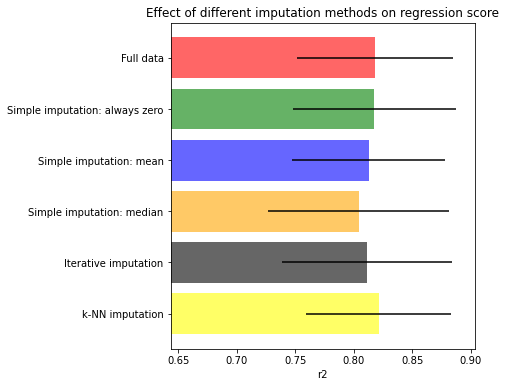

In [18]:
### Plot results
### This plotting code adapted from scikit-learn impute documentation.

n_bars = n_entries
xval   = np.arange(n_bars)

colors = ['r', 'g', 'b', 'orange', 'black', 'yellow']

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_dataset[j], xerr=stds_dataset[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Effect of different imputation methods on regression score')
ax1.set_xlim(left=np.min(mses_dataset) * 0.8,
             right=np.max(mses_dataset) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel(score_type)
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()